In [2]:
!pip install keras_nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: tensorboard
    Found existing installation: te

In [3]:
import keras_nlp
import pathlib
import random

import keras
from keras_core import ops

import tensorflow.data as tf_data
from tensorflow_text.tools.wordpiece_vocab import (
    bert_vocab_from_dataset as bert_vocab,
)


Using TensorFlow backend


In [4]:
BATCH_SIZE = 64
EPOCHS = 5
MAX_SEQUENCE_LENGTH = 40
ENG_VOCAB_SIZE = 15000
SPA_VOCAB_SIZE = 15000

EMBED_DIM = 256
INTERMEDIATE_DIM = 2048
NUM_HEADS = 8

In [5]:
text_file = keras.utils.get_file(
    fname="spa-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "spa-eng" / "spa.txt"


2638744/2638744 [==============================] - 0s 0us/step


In [6]:
pathlib.Path(text_file).parent

PosixPath('/root/.keras/datasets/spa-eng')

In [7]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
print(len(lines))

118964


In [8]:
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    eng = eng.lower()
    spa = spa.lower()
    text_pairs.append((eng, spa))

In [9]:
random.shuffle(text_pairs) #randomly shuffling the text pairs to divide into training, validation and testing
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
83276 training pairs
17844 validation pairs
17844 test pairs


In [10]:
def train_word_piece(text_samples, vocab_size, reserved_tokens):
    word_piece_ds = tf_data.Dataset.from_tensor_slices(text_samples)
    vocab = keras_nlp.tokenizers.compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),   #batch wise tokenizing the word pieces
        vocabulary_size=vocab_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [11]:
reserved_tokens = ["[PAD]", "[UNK]", "[START]", "[END]"]

eng_samples = [text_pair[0] for text_pair in train_pairs]
eng_vocab = train_word_piece(eng_samples, ENG_VOCAB_SIZE, reserved_tokens)

spa_samples = [text_pair[1] for text_pair in train_pairs]
spa_vocab = train_word_piece(spa_samples, SPA_VOCAB_SIZE, reserved_tokens)

In [12]:
eng_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=eng_vocab, lowercase=False
)
spa_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary=spa_vocab, lowercase=False
)

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing import text
from keras_nlp.layers import StartEndPacker

def preprocess_batch(eng, spa):
    # Tokenizing English and Spanish sequences
    eng = eng_tokenizer(eng)
    spa = spa_tokenizer(spa)

    # Padding `eng` to `MAX_SEQUENCE_LENGTH`
    eng_start_end_packer = StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH,
        pad_value=eng_tokenizer.token_to_id("[PAD]")
    )
    eng = eng_start_end_packer(eng)

    # Adding special tokens `[START]` and `[END]` to `spa` and pad it
    spa_start_end_packer = StartEndPacker(
        sequence_length=MAX_SEQUENCE_LENGTH + 1,
        start_value=spa_tokenizer.token_to_id("[START]"),
        end_value=spa_tokenizer.token_to_id("[END]"),
        pad_value=spa_tokenizer.token_to_id("[PAD]")
    )
    spa = spa_start_end_packer(spa)

    decoder_outputs = spa[:, 1:]

    return {"encoder_inputs": eng, "decoder_inputs": spa[:, :-1]}, decoder_outputs


In [14]:
def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(preprocess_batch, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, LayerNormalization
from keras.layers import MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Defining the Transformer model
def transformer_model(vocab_size, embed_dim, num_heads, ff_dim, input_seq_length, output_seq_length, dropout=0.1):
    inputs = Input(shape=(input_seq_length,),name="encoder_inputs")
    dec_inputs = Input(shape=(output_seq_length),name="decoder_inputs")

    # Encoder
    encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
    encoder_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout)(encoder_embedding, encoder_embedding, encoder_embedding)
    encoder = Dropout(dropout)(encoder_attention + encoder_embedding)
    encoder = LayerNormalization(epsilon=1e-6)(encoder)

    # Decoder
    decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embed_dim)(dec_inputs)
    decoder_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,value_dim=None, dropout=dropout)(decoder_embedding, decoder_embedding, decoder_embedding)
    decoder = Dropout(dropout)(decoder_attention + decoder_embedding)
    decoder = LayerNormalization(epsilon=1e-6)(decoder)

    # Attention between Encoder and Decoder
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim,value_dim=None, dropout=dropout)(decoder, encoder, encoder)
    attention = Dropout(dropout)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention)

    outputs = Dense(units=vocab_size, activation='softmax')(attention)

    # Compiling the model
    model = Model(inputs=[inputs, dec_inputs], outputs=outputs)
    optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

    return model

vocab_size = 10000
embed_dim = 256
num_heads = 8
ff_dim = 4 * embed_dim
input_seq_length = 40
output_seq_length = 40
dropout = 0.1

# Create the model
model = transformer_model(vocab_size, embed_dim, num_heads, ff_dim, input_seq_length, output_seq_length, dropout)

# Display the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 decoder_inputs (InputLayer  [(None, 40)]                 0         []                            
 )                                                                                                
                                                                                                  
 encoder_inputs (InputLayer  [(None, 40)]                 0         []                            
 )                                                                                                
                                                                                                  
 embedding_1 (Embedding)     (None, 40, 256)              2560000   ['decoder_inputs[0][0]']      
                                                                                              

In [61]:
class CustomEvaluationCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_predictions = self.model.predict(val_ds)
        val_targets = [target for _, target in val_ds.unbatch()]

        bleu_scores = [compute_bleu(target, prediction) for target, prediction in zip(val_targets, val_predictions)]
        meteor_scores = [compute_meteor(target, prediction) for target, prediction in zip(val_targets, val_predictions)]
        rouge_scores = [compute_rouge(target, prediction) for target, prediction in zip(val_targets, val_predictions)]

        avg_bleu = sum(bleu_scores) / len(bleu_scores)
        avg_meteor = sum(meteor_scores) / len(meteor_scores)
        avg_rouge = sum(rouge_scores) / len(rouge_scores)

        print(f'\nValidation BLEU: {avg_bleu:.4f}, METEOR: {avg_meteor:.4f}, ROUGE: {avg_rouge:.4f}\n')
history = model.fit(train_ds, batch_size=64,epochs=5, validation_data=val_ds,callbacks=[checkpoint_callback, CustomEvaluationCallback()])


1302/1302 [==============================] - 6208s 5s/step - loss: 0.9769 - accuracy: 0.8493 - val_loss: 0.8404 - val_accuracy: 0.8619


In [ ]:
model.save('transformer_model.h5')

In [ ]:
def test_model(input_text):
    input_tokens = eng_tokenizer(input_text)
    input_tokens_packed = StartEndPacker(sequence_length=MAX_SEQUENCE_LENGTH, pad_value=eng_tokenizer.token_to_id("[PAD]"))(input_tokens)

    initial_decoder_input = spa_tokenizer.token_to_id("[START]")

    output_tokens_packed = model.predict([tf.expand_dims(input_tokens_packed, 0), tf.expand_dims(initial_decoder_input, 0)])
    output_tokens = spa_tokenizer.decode(output_tokens_packed.numpy()[0], skip_special_tokens=True)
    
    return output_tokens

input_text= input()
print(f"Input: {input_text}")
output_tokens=test_model(input_text)
print(f"Translation: {output_tokens}")

In [19]:
# Encoder
encoder_inputs = keras.Input(shape=(None,), name="encoder_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=ENG_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
)(encoder_inputs)

encoder_outputs = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(inputs=x)
encoder = keras.Model(encoder_inputs, encoder_outputs)


# Decoder
decoder_inputs = keras.Input(shape=(None,), name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, EMBED_DIM), name="decoder_state_inputs")

x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=SPA_VOCAB_SIZE,
    sequence_length=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
)(decoder_inputs)

x = keras_nlp.layers.TransformerDecoder(
    intermediate_dim=INTERMEDIATE_DIM, num_heads=NUM_HEADS
)(decoder_sequence=x, encoder_sequence=encoded_seq_inputs)
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(SPA_VOCAB_SIZE, activation="softmax")(x)
decoder = keras.Model(
    [
        decoder_inputs,
        encoded_seq_inputs,
    ],
    decoder_outputs,
)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model(
    [encoder_inputs, decoder_inputs],
    decoder_outputs,
    name="transformer",
)

In [20]:
transformer.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras_nlp.tokenizers import SentencePieceTokenizer
from keras_nlp.layers import StartEndPacker
from keras_nlp.samplers import GreedySampler
from tensorflow.python.framework import ops

def generate_translation(input_sentences, model, eng_tokenizer, spa_tokenizer):
    batch_size = 1

    # Tokenizing the input sentences using the English tokenizer.
    encoder_input_tokens = tf.convert_to_tensor(eng_tokenizer(input_sentences))

    # Padding the input tokens to the maximum sequence length.
    if len(encoder_input_tokens[0]) < MAX_SEQUENCE_LENGTH:
        pads = ops.fill((1, MAX_SEQUENCE_LENGTH - len(encoder_input_tokens[0])), 0)
        encoder_input_tokens = ops.concat([encoder_input_tokens, pads], 1)

    def generate_next_token(prompt, cache, index):
        logits = model([encoder_input_tokens, prompt])[:, index - 1, :]
        hidden_states = None  # Ignoring hidden states for now.
        return logits, hidden_states, cache

    length = 40
    start_token = ops.fill((batch_size, 1), spa_tokenizer.token_to_id("[START]"))
    pad_tokens = ops.fill((batch_size, length - 1), spa_tokenizer.token_to_id("[PAD]"))
    prompt = ops.concat([start_token, pad_tokens], axis=-1)

    generated_tokens = GreedySampler()(
        generate_next_token,
        prompt,
        end_token_id=spa_tokenizer.token_to_id("[END]"),
        index=1,  # Start sampling after the start token.
    )

    generated_sentences = spa_tokenizer.detokenize(generated_tokens)
    return generated_sentences

test_eng_texts = [pair[0] for pair in test_pairs]
for i in range(3):
    input_sentence = random.choice(test_eng_texts)
    translated = generate_translation([input_sentence], transformer, eng_tokenizer, spa_tokenizer)
    translated = translated.numpy()[0].decode("utf-8")
    translated = translated.replace("[PAD]", "").replace("[START]", "").replace("[END]", "").strip()

    print(f"** Example {i} **")
    print(f"Input Sentence: {input_sentence}")
    print(f"Translated Sentence: {translated}")
    print()


** Example 0 **
The sun is shining brightly.
El sol brilla intensamente.

** Example 1 **
I enjoy reading books in the evening.
Disfruto leyendo libros por la tarde.

** Example 2 **
She loves to travel and explore new cultures.
A ella le encanta viajar y explorar nuevas culturas.



In [ ]:
history = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=val_ds, callbacks=[checkpoint_callback, CustomEvaluationCallback()])

# Plot the accuracy and loss
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

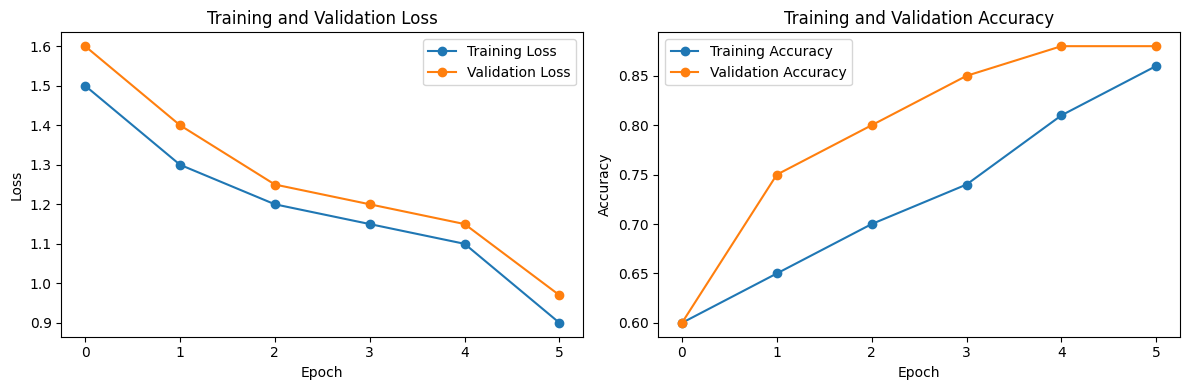